In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df_order_main = pd.read_excel('...\\Per_Barcode_per_day_per_vendor.xlsx')

In [7]:
df_product_main = pd.read_excel('...\\ExpressMaster.xlsx')

### Making Order and Product Dataframes

In [8]:
df_order_main
df_order = df_order_main.drop(df_order_main[df_order_main['Barcode']==''].index)

In [9]:
df_order['sale'] = df_order['#']*df_order['$']
df_order

,Date,VendorID,OrderID,UserID,City,Barcode,SubCat,#,$,sale
0,2021-10-01,53048.0,154341113,6636536,شیراز,6261792001949,نظافت و شستشو,1,24550.0,24550.0
1,2021-10-01,53048.0,154343076,1478883,شیراز,80177173,محصولات صبحانه,1,100000.0,100000.0
2,2021-10-01,53048.0,154346508,260665,شیراز,6260002932776,چیپس،پفک،پاپ کورن,2,18000.0,36000.0
3,2021-10-01,53048.0,154346508,260665,شیراز,6260687301935,پنیر,1,22500.0,22500.0
4,2021-10-01,53048.0,154346508,260665,شیراز,6262477911164,آجیل، چیپس میوه,2,10000.0,20000.0
...,...,...,...,...,...,...,...,...,...,...
698825,2021-10-26,96695.0,160974809,4278163,قم,6260176817312,بستنی و فالوده,3,12000.0,36000.0
698826,2021-10-26,96695.0,161012223,10378476,قم,6260031022035,مراقبت و آرایش مو,1,13460.0,13460.0
698827,2021-10-26,96695.0,161013804,4071003,قم,2770200021,سبزیجات و صیفی جات,1,10000.0,10000.0
698828,2021-10-26,96695.0,161027637,9845699,قم,6260176822736,بستنی و فالوده,2,6000.0,12000.0


In [10]:
df_product_main

,productID,productName,barcode,subCatID,subCatName,catName,brandName,menuActive,productActive
0,7550641,فاميلي برنج 3 كيلويي سوپر اعلاء هاشمي,12050,550105,بسته های پیشنهادی,غیر فعال,NaN,0,1
1,7550637,صاف مايع جرمگير 700 گرم,309162,550105,بسته های پیشنهادی,غیر فعال,NaN,0,1
2,7550596,پرسيل مايع لباسشويي لاوندرض1.700 كيلو گرم,375141,550105,بسته های پیشنهادی,غیر فعال,NaN,0,1
3,7550594,پاك شير سنتي كم چرب شيشه اي 1 ليتر,20026561,550105,بسته های پیشنهادی,غیر فعال,NaN,0,1
4,7550593,بايوبيت روغن زيتون بي بو 1 ليتر,359137,550105,بسته های پیشنهادی,غیر فعال,NaN,0,1
...,...,...,...,...,...,...,...,...,...
178489,6792019,تنباکو طعم انگور نعناع (50 گرم),6291107685373,391129,ذغال، تنباکو و توتون,دخانیات,NaN,0,0
178490,6792018,تنباکو طعم طالبی (50 گرم),6291107684666,391129,ذغال، تنباکو و توتون,دخانیات,NaN,0,0
178491,6792017,تنباکو طعم لیمو و نعناع الشرق (50 گرم),6291106963717,391129,ذغال، تنباکو و توتون,دخانیات,الشرق,0,0
178492,6792015,تنباکو طعم دو سیب الفاخر (50 گرم),6291100731077,391129,ذغال، تنباکو و توتون,دخانیات,الفاخر,0,0


In [11]:
df_order.fillna('',inplace= True)
df_order['Date']= pd.to_datetime(df_order['Date'])
df_order['VendorID'] = df_order['VendorID'].astype('Int32')
df_order['OrderID'] = df_order['OrderID'].astype('Int32')
df_order['UserID'] = df_order['UserID'].astype('Int32')
df_order['#'] = df_order['#'].astype('int32')
df_order['$'] = df_order['$'].astype('int32')
df_order['sale'] = df_order['sale'].astype('int64')
df_order.columns = ['date','vendorID','orderID','userID','city','barcode','subCat','qty','price','sale']

In [12]:
df_product = df_product_main.drop(['brandName','menuActive','productActive'], axis=1)
df_product.drop(df_product[df_product['barcode'].isnull()].index, inplace=True)
df_product = df_product[df_product['catName']=='لبنیات و بستنی']

In [13]:
pd.set_option("display.max_colwidth", None)

In [14]:
df_product

,productID,productName,barcode,subCatID,subCatName,catName
371,6791669,ماست موسیر چکیده مزرعه‌ماهشام (500 گرم),6262514601201,390197,ماست,لبنیات و بستنی
372,6791590,پنیر پیتزا رنده‌شده کالین (500 گرم),6261551602417,390198,پنیر,لبنیات و بستنی
373,5914168,ماست پروبیوتیک کم‌چرب پاک (750 گرم),6260063204447,390197,ماست,لبنیات و بستنی
374,5914159,ماست گاو‌میش پرچرب پگاه (800 گرم),6260007462964,390197,ماست,لبنیات و بستنی
375,5914156,ماست نیم‌چرب 1.5٪ پگاه (700 گرم),6260007416738,390197,ماست,لبنیات و بستنی
...,...,...,...,...,...,...
11093,6804801,کره حیوانی پاک (50 گرم),6260063262669,390200,کره,لبنیات و بستنی
11094,6791996,کافی میکس ونزکافه,6269816900025,390175,شیر,لبنیات و بستنی
11095,6791977,پودر شکلات داغ واگنر (250 گرم),6269629900052,390175,شیر,لبنیات و بستنی
11096,6791932,ماست کم‌چرب 1.3٪ مزرعه‌ماهشام (یک کیلوگرم),6268714601706,390197,ماست,لبنیات و بستنی


In [15]:
df_order

,date,vendorID,orderID,userID,city,barcode,subCat,qty,price,sale
0,2021-10-01,53048,154341113,6636536,شیراز,6261792001949,نظافت و شستشو,1,24550,24550
1,2021-10-01,53048,154343076,1478883,شیراز,80177173,محصولات صبحانه,1,100000,100000
2,2021-10-01,53048,154346508,260665,شیراز,6260002932776,چیپس،پفک،پاپ کورن,2,18000,36000
3,2021-10-01,53048,154346508,260665,شیراز,6260687301935,پنیر,1,22500,22500
4,2021-10-01,53048,154346508,260665,شیراز,6262477911164,آجیل، چیپس میوه,2,10000,20000
...,...,...,...,...,...,...,...,...,...,...
698825,2021-10-26,96695,160974809,4278163,قم,6260176817312,بستنی و فالوده,3,12000,36000
698826,2021-10-26,96695,161012223,10378476,قم,6260031022035,مراقبت و آرایش مو,1,13460,13460
698827,2021-10-26,96695,161013804,4071003,قم,2770200021,سبزیجات و صیفی جات,1,10000,10000
698828,2021-10-26,96695,161027637,9845699,قم,6260176822736,بستنی و فالوده,2,6000,12000


### Extractall the units and their values

In [24]:
df1=df_product['productName'].str.extractall(r'\D*(\d+[.,]?\d*)(\s*)?(گرم)?(gr)?(lit)?(ML)?(Lit)?(ml)?(کیلو)?(میلی)?(لیتر)?( سی )?(سانت)?(عدد)?( تا )?(پاکت)?(ميل)?(ليتر)?(كيلو)?(برگ)?(مثقال)?(بسته)?(باکس)?(جفت)?(mg)?(قطعه)?(نفر)?(متر)?(Kg)?(میل)?(کرم)?(کبلوگرم)?\D*')
df2=df_product['productName'].str.extract(r'\D*(یک)(\s*)?(گرم)?(gr)?(lit)?(ML)?(Lit)?(ml)?(کیلو)?(میلی)?(لیتر)?( سی )?(سانت)?(عدد)?( تا )?(پاکت)?(ميل)?(ليتر)?(كيلو)?(برگ)?(مثقال)?(بسته)?(باکس)?(جفت)?(mg)?(قطعه)?(نفر)?(متر)?(Kg)?(میل)?(کرم)?(کبلوگرم)?\D*')

In [26]:
df1.index = df1.index.set_names(['first', 'second'])

In [28]:
df2['productName']= df_product['productName']
df2['productID']= df_product['productID']

In [29]:
df1 = pd.merge(df1,df2[['productID','productName']],right_index=True, left_on='first', how='inner')

In [31]:
df1 = df1.reset_index()

In [33]:
df1.drop(['first','second'],axis=1,inplace=True)

### Concatenating the unit differenet values, Deleting rows that are not unit related.

In [35]:
df1.fillna('', inplace=True)
df2.fillna('', inplace=True)

In [40]:
df1

,productID,productName,unit,value
0,6791669,ماست موسیر چکیده مزرعه‌ماهشام (500 گرم),گرم,500
1,6791590,پنیر پیتزا رنده‌شده کالین (500 گرم),گرم,500
2,5914168,ماست پروبیوتیک کم‌چرب پاک (750 گرم),گرم,750
3,5914159,ماست گاو‌میش پرچرب پگاه (800 گرم),گرم,800
4,5914156,ماست نیم‌چرب 1.5٪ پگاه (700 گرم),,1.5
...,...,...,...,...
8770,8467559,ماست موسیر چکیده ایساتیس (200 گرم),گرم,200
8771,6804801,کره حیوانی پاک (50 گرم),گرم,50
8772,6791977,پودر شکلات داغ واگنر (250 گرم),گرم,250
8773,6791932,ماست کم‌چرب 1.3٪ مزرعه‌ماهشام (یک کیلوگرم),,1.3


In [37]:
df1['unit'] = df1.iloc[:,2]
for i in range(3,32):
    df1['unit'] = df1.iloc[:,i] + df1['unit']
df2['unit'] = df2.iloc[:,2]
for i in range(3,32):
    df2['unit'] = df2.iloc[:,i] + df2['unit']
df1['value'] = df1.iloc[:,0]
df2['value'] = df2.iloc[:,0]

In [39]:
df1 = df1[['productID','productName','unit','value']]
df2 = df2[['productID','productName','unit','value']]

In [41]:
df1.drop(df1[df1['unit']==''].index, inplace=True)
df2.drop(df2[df2['unit']==''].index, inplace=True)
df2['value'].replace('یک','1',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [42]:
df1

,productID,productName,unit,value
0,6791669,ماست موسیر چکیده مزرعه‌ماهشام (500 گرم),گرم,500
1,6791590,پنیر پیتزا رنده‌شده کالین (500 گرم),گرم,500
2,5914168,ماست پروبیوتیک کم‌چرب پاک (750 گرم),گرم,750
3,5914159,ماست گاو‌میش پرچرب پگاه (800 گرم),گرم,800
5,5914156,ماست نیم‌چرب 1.5٪ پگاه (700 گرم),گرم,700
...,...,...,...,...
8769,8467560,پنیر خامه‌ای ایساتیس (100 گرم),گرم,100
8770,8467559,ماست موسیر چکیده ایساتیس (200 گرم),گرم,200
8771,6804801,کره حیوانی پاک (50 گرم),گرم,50
8772,6791977,پودر شکلات داغ واگنر (250 گرم),گرم,250


In [43]:
df2

,productID,productName,unit,value
385,5914301,بستنی وانیلی پرستیژ شیرین‌عسل (یک لیتر),لیتر,1
581,5919524,شیرکاکائو مووو شیرین‌عسل (یک لیتر),لیتر,1
586,5914385,بستنی تیرامیسو ویکتوریا دومینو (یک لیتر),لیتر,1
590,5914381,بستنی قهوه ویکتوریا دومینو (یک لیتر),لیتر,1
696,5922931,شیر جوشیده شده مرسا (یک لیتر),لیتر,1
...,...,...,...,...
11067,7999343,پنیر پیتزا فود‌فود (یک کیلوگرم),کیلو,1
11072,7998831,بستنی زعفرانی به‌تک (یک لیتر),لیتر,1
11073,7998830,بستنی وانیلی به‌تک (یک لیتر),لیتر,1
11092,6804802,پنیر گوسفندی لیقوان آراز‌لبن (یک کیلوگرم),کیلو,1


### Merging extract final results with each other and the original product df (deleting rows with two products in two dataframes and in the same dataframe)

In [44]:
df = pd.merge(df1,df2,on='productID',how='outer')
df.fillna('',inplace=True)

In [46]:
df_concat = df[(df['unit_x']!='') & (df['unit_y']!='')]

In [48]:
df_same_concat =df[df['productID'].duplicated() & ~df['unit_x'].str.contains('عدد')]

In [50]:
df = pd.merge(df_product,df, on='productID', how='outer')

In [52]:
df = df[~df.productID.isin(df_concat.productID)]

In [53]:
df = df[~df.productID.isin(df_same_concat.productID)]

In [54]:
df.fillna('',inplace=True)
df.drop(['productName_x','productName_y'],axis=1,inplace=True)

### Saving rows without units or non-numeric units, replacing with numeric values manually by importing and merging file with dataframe 

In [55]:
df_null = df[(df['unit_x']=='') & (df['unit_y']=='')]

In [56]:
df_adad = df[df['unit_x'].str.contains('عدد')]
df_adad = df_adad.append(df[df['unit_y'].str.contains('عدد')])

In [967]:
df_null.to_excel('...\\without_unit.xlsx')
df_adad.to_excel('...\\adad_unit.xlsx')

In [57]:
df_units = pd.read_excel('...\\Units_Values.xlsx')

In [58]:
df_units

,Unnamed: 0,productID,productName,barcode,subCatID,subCatName,catName,value,unit
0,870,5980439,شیرکاکائو شاد,6261323900482,390175,شیر,لبنیات و بستنی,800,گرم
1,1331,5981440,شیرکاکائو شاد,6261323901021,390175,شیر,لبنیات و بستنی,800,گرم
2,1688,6456687,شیرکاکائو میعاد,6261767001226,390175,شیر,لبنیات و بستنی,900,گرم
3,3645,4410820,پودر كاپوچینو فوری گوددی,8991002103764,390175,شیر,لبنیات و بستنی,750,گرم
4,3968,7354739,شیر پر‌چرب مزرعه‌ماهشام,9268254601195,390175,شیر,لبنیات و بستنی,945,میلی لیتر
...,...,...,...,...,...,...,...,...,...
78,4430,6596646,کره سیر شکلی (15 گرم) 8 عدد,6260298402649,390200,کره,لبنیات و بستنی,120,گرم
79,4432,6596645,کره سیر و سبزیجات شکلی (15 گرم) 8 عدد,6260298402632,390200,کره,لبنیات و بستنی,120,گرم
80,559,5967837,یخمک پرتقالی آیس‌لپ لپ‌لپ (یک عدد),6263276600372,390202,بستنی و فالوده,لبنیات و بستنی,50,گرم
81,5147,6017822,یخمک میوه‌ای (یک عدد),3901745010,390202,بستنی و فالوده,لبنیات و بستنی,50,گرم


In [60]:
df['value_x'] = df['value_x'] + df['value_y']
df['unit_x'] = df['unit_x'] + df['unit_y']

### Removing rows without units, with non-numeric units

In [61]:
df = df[~df.productID.isin(df_adad.productID)]

In [62]:
df = df[~df.productID.isin(df_null.productID)]

In [63]:
df[['barcode','unit_x']] = df[['barcode','unit_x']].astype('object')
df_units[['barcode','unit']] = df_units[['barcode','unit']].astype('object')

In [64]:
df = pd.merge (df , df_units, 
               left_on=['productID','productName','barcode','subCatID','subCatName','catName'],
               right_on=['productID','productName','barcode','subCatID','subCatName','catName'],
               how='outer')

In [65]:
df.fillna('',inplace=True)

In [66]:
condition1 = [(df['value']==''),(df['value']!='')]
choices = [df.loc[:,'value_x'], df.loc[:,'value']]
df['value'] = np.select(condition1,choices, default=0)
condition2 = [(df['unit']==''),(df['unit']!='')]
choices = [df.loc[:,'unit_x'], df.loc[:,'unit']]
df['unit'] = np.select(condition2,choices, default=0)
df.drop(['unit_x','value_x','unit_y','value_y','Unnamed: 0'], axis=1, inplace=True)
df['value'] = df['value'].astype('float')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6730 entries, 0 to 6729
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productID    6730 non-null   int64  
 1   productName  6730 non-null   object 
 2   barcode      6730 non-null   object 
 3   subCatID     6730 non-null   int64  
 4   subCatName   6730 non-null   object 
 5   catName      6730 non-null   object 
 6   value        6730 non-null   float64
 7   unit         6730 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 473.2+ KB


### Split Data due to Subcategory

In [68]:
dtf = [d for _, d in df.groupby(['subCatID'])]

### Getting the units of each product and uniting all row's units (numeric ones) for each subcategory subset.

In [69]:
for i in range(0,len(dtf)):
    dtf[i].fillna('',inplace=True)
    dtf[i]['productID'] = dtf[i]['productID'].astype('Int32')
    dtf[i]['subCatID'] =  dtf[i]['subCatID'].astype('Int32')
    print('subcat Number%s'%i)
    print(dtf[i].subCatName.unique())
    print(dtf[i].subCatID.unique())
    print(dtf[i].unit.unique())

subcat Number0
['شیر']
<IntegerArray>
[390175]
Length: 1, dtype: Int32
['میلی' 'لیتر' 'گرم' 'کیلو' 'میل' 'لیترمیلی' 'میلی لیتر']
subcat Number1
['ماست']
<IntegerArray>
[390197]
Length: 1, dtype: Int32
['گرم' 'کیلو' 'لیتر' 'میلی' 'کبلوگرم' 'کیلوگرم']
subcat Number2
['پنیر']
<IntegerArray>
[390198]
Length: 1, dtype: Int32
['گرم' 'کیلو' 'کرم']
subcat Number3
['خامه']
<IntegerArray>
[390199]
Length: 1, dtype: Int32
['گرم' 'میلی' 'کیلو']
subcat Number4
['کره']
<IntegerArray>
[390200]
Length: 1, dtype: Int32
['گرم' 'کیلو']
subcat Number5
['کشک']
<IntegerArray>
[390201]
Length: 1, dtype: Int32
['گرم' 'کیلو' 'میلی']
subcat Number6
['بستنی و فالوده']
<IntegerArray>
[390202]
Length: 1, dtype: Int32
['گرم' 'لیتر' 'کیلو' 'میلی']
subcat Number7
['لبنیات گیاهی']
<IntegerArray>
[713878]
Length: 1, dtype: Int32
['میلی' 'گرم' 'لیتر']


In [70]:
for i in range(0,len(dtf)):
    if dtf[i].subCatName.unique() == ['شیر'] or dtf[i].subCatName.unique() == ['لبنیات گیاهی']:
        conditions = [(dtf[i]['unit'] == 'لیتر'),(dtf[i]['unit'] == 'میلی\u200cلیتر'),(dtf[i]['unit'] == 'میلی لیتر'),
                      (dtf[i]['unit'] == 'گرم'),(dtf[i]['unit'] == 'لیترمیلی'),(dtf[i]['unit'] == 'میل'),(dtf[i]['unit'] == 'میلی'),
                      (dtf[i]['unit'] == 'کیلو')]
        choices = [dtf[i]['value']*1000, dtf[i]['value'], dtf[i]['value'], dtf[i]['value'], dtf[i]['value'], dtf[i]['value'],
                   dtf[i]['value'],dtf[i]['value']*1000]
        dtf[i]['unit'] = 'میلی لیتر'
    elif dtf[i].subCatName.unique() == ['بستنی و فالوده']:
        conditions = [(dtf[i]['unit'] == 'گرم'),(dtf[i]['unit'] == 'لیتر'), (dtf[i]['unit'] == 'کیلو'),(dtf[i]['unit'] == 'میلی')]
        choices = [dtf[i]['value'] , dtf[i]['value']*554, dtf[i]['value']*1000, dtf[i]['value']*0.554]
        dtf[i]['unit'] = 'گرم'
    else:
        conditions = [(dtf[i]['unit'] == 'گرم'),(dtf[i]['unit'] == 'کیلو'),(dtf[i]['unit'] == 'کبلوگرم'),
                   (dtf[i]['unit'] == 'میلی'),(dtf[i]['unit'] == 'کیلوگرم'),(dtf[i]['unit'] == 'لیتر'),(dtf[i]['unit'] == 'کرم')]
        choices = [dtf[i]['value'],dtf[i]['value']*1000,dtf[i]['value']*1000, dtf[i]['value'],
                dtf[i]['value']*1000, dtf[i]['value']*1000,dtf[i]['value']]
        dtf[i]['unit'] = 'گرم'
    dtf[i]['value'] = np.select(conditions,choices, default=0)

### Market Share and Weighted Distribution Calculations for each subcategory dataset

In [71]:
df_order['totalSale'] = df_order.groupby('barcode')['sale'].transform('sum')
df_order['avgPrice'] = df_order.groupby('barcode')['price'].transform('mean')
df_order.avgPrice = df_order.avgPrice.round()
df_order['storeTurnover'] = df_order.groupby('vendorID')['sale'].transform('sum')
df_order['productStoreTurnover'] = df_order.groupby('barcode')['storeTurnover'].transform('sum')
df_order['customerNum'] = df_order.groupby('barcode')['userID'].transform('nunique')
df_order['customerNum'] = df_order['customerNum'].astype('Int32')
df_order['avgPrice'] = df_order['avgPrice'].astype('Int32')
df_join = df_order.drop_duplicates('barcode')

In [72]:
df_order

,date,vendorID,orderID,userID,city,barcode,subCat,qty,price,sale,totalSale,avgPrice,storeTurnover,productStoreTurnover,customerNum
0,2021-10-01,53048,154341113,6636536,شیراز,6261792001949,نظافت و شستشو,1,24550,24550,795903,27850,441878161,4609186659,18
1,2021-10-01,53048,154343076,1478883,شیراز,80177173,محصولات صبحانه,1,100000,100000,19470350,99223,441878161,41750057926,138
2,2021-10-01,53048,154346508,260665,شیراز,6260002932776,چیپس،پفک،پاپ کورن,2,18000,36000,22479876,10337,441878161,328778470668,1452
3,2021-10-01,53048,154346508,260665,شیراز,6260687301935,پنیر,1,22500,22500,2615800,23185,441878161,34300441979,100
4,2021-10-01,53048,154346508,260665,شیراز,6262477911164,آجیل، چیپس میوه,2,10000,20000,36250450,7527,441878161,510144494430,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698825,2021-10-26,96695,160974809,4278163,قم,6260176817312,بستنی و فالوده,3,12000,36000,18127000,8478,30470615,133093801768,549
698826,2021-10-26,96695,161012223,10378476,قم,6260031022035,مراقبت و آرایش مو,1,13460,13460,450244,13839,30470615,4033556797,27
698827,2021-10-26,96695,161013804,4071003,قم,2770200021,سبزیجات و صیفی جات,1,10000,10000,6507254,13910,30470615,68155246635,280
698828,2021-10-26,96695,161027637,9845699,قم,6260176822736,بستنی و فالوده,2,6000,12000,2775000,5977,30470615,19326490022,125


In [73]:
for i in range(0,len(dtf)):
    dtf[i] = dtf[i].merge(df_join[['totalSale','productStoreTurnover','barcode','avgPrice','customerNum']], how='left', on='barcode')
    dtf[i].drop(dtf[i][dtf[i]['productID'].isnull()].index,inplace=True)
    dtf[i].drop(dtf[i][dtf[i]['totalSale'].isnull()].index,inplace=True)
    dtf[i]['marketShare'] = dtf[i]['totalSale']/(dtf[i]['totalSale'].sum())
    dtf[i]['penetration'] = dtf[i]['customerNum']/(dtf[i]['customerNum'].sum())
    dtf[i]['wghtDist'] = dtf[i]['productStoreTurnover']/(dtf[i]['productStoreTurnover'].sum())
    dtf[i].fillna('',inplace=True)
    dtf[i].reset_index(drop=True,inplace=True)

In [74]:
for i in range(0,len(dtf)):
    print(dtf[i].shape)

(343, 15)
(432, 15)
(445, 15)
(86, 15)
(139, 15)
(75, 15)
(599, 15)
(21, 15)


### Normalize metrics (weight, price) & data binning

In [75]:
group_names = ['very_low','low','medium','high','very_high']    
for i in range(0,len(dtf)):
    dtf[i]['n_value'] = dtf[i]['value']/dtf[i]['value'].sum()
    dtf[i]['n_avgPrice'] = dtf[i]['avgPrice']/dtf[i]['avgPrice'].sum()
    bins = np.linspace(min(dtf[i]['totalSale']), max(dtf[i]['totalSale']),6)
    dtf[i]['totalSale_binned']= pd.cut(dtf[i]['totalSale'],bins, labels = group_names, include_lowest=True)
    bins = np.linspace(min(dtf[i]['value']), max(dtf[i]['value']),6)
    dtf[i]['value_binned']= pd.cut(dtf[i]['value'],bins, labels = group_names, include_lowest=True)
    bins = np.linspace(min(dtf[i]['avgPrice']), max(dtf[i]['avgPrice']),6)
    dtf[i]['avgPrice_binned']= pd.cut(dtf[i]['avgPrice'],bins, labels = group_names, include_lowest=True)

## Clustering

In [76]:
from sklearn.cluster import KMeans

In [77]:
kmeans_6 = KMeans(n_clusters = 6)
kmeans_3= KMeans(n_clusters=3)
kmeans_2 = KMeans(n_clusters=2)

In [78]:
label={}
label_2={}
for i in range(0,len(dtf)):
    if dtf[i].subCatName.unique() == ['شیر'] or dtf[i].subCatName.unique() == ['ماست'] or dtf[i].subCatName.unique() == ['پنیر'] or dtf[i].subCatName.unique() == ['بستنی و فالوده']:
        kmeans_6.fit(dtf[i][['n_value','n_avgPrice']])
        label[i]= kmeans_6.labels_
    else:
        kmeans_3.fit(dtf[i][['n_value','n_avgPrice']])
        label[i]= kmeans_3.labels_
    dtf[i]['cluster'] = label[i]
    dtf[i]['cluster_2']=np.nan
    for j in range(0,len(label[i])):
        if len(dtf[i][dtf[i]['cluster']==j])>2:
            kmeans_3.fit(dtf[i][['marketShare','penetration','wghtDist']][dtf[i]['cluster']==j])
            label_2[i]=kmeans_3.labels_
            dtf[i]['cluster_2'][dtf[i]['cluster']==j] = label_2[i]
            dtf[i]['cluster_2'].fillna(0,inplace=True)
            dtf[i]['cluster_2'] = dtf[i]['cluster_2'].astype('int32')
        else:
            dtf[i]['cluster_2'][dtf[i]['cluster']==j] =0
            dtf[i]['cluster_2'].fillna(0,inplace=True)
            dtf[i]['cluster_2'] = dtf[i]['cluster_2'].astype('int32')

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15888/2529565557.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf[i]['cluster_2'][dtf[i]['cluster']==j] = label_2[i]
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15888/2529565557.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf[i]['cluster_2'][dtf[i]['cluster']==j] = label_2[i]
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15888/2529565557.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15888/2529565557.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf[i]['cluster_2'][dtf[i]['cluster']==j] = label_2[i]
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15888/2529565557.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf[i]['cluster_2'][dtf[i]['cluster']==j] = label_2[i]
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_15888/2529565557.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [79]:
final_df=pd.DataFrame()
for i in range(0,len(dtf)):
    final_df = final_df.append(dtf[i],ignore_index=True)

In [80]:
final_df

,productID,productName,barcode,subCatID,subCatName,catName,value,unit,totalSale,productStoreTurnover,...,marketShare,penetration,wghtDist,n_value,n_avgPrice,totalSale_binned,value_binned,avgPrice_binned,cluster,cluster_2
0,5919586,شیرقهوه 1.5٪ پگاه (200 میلی‌لیتر),6260007406470,390175,شیر,لبنیات و بستنی,200.0,میلی لیتر,438000.0,1.912706e+09,...,0.000454,0.000466,0.000251,0.000969,0.002156,very_low,very_low,very_low,0,0
1,5919584,شیرکاکائو کم‌چرب پگاه (200 میلی‌لیتر),6260007450732,390175,شیر,لبنیات و بستنی,200.0,میلی لیتر,297000.0,1.646613e+09,...,0.000308,0.000333,0.000216,0.000969,0.002143,very_low,very_low,very_low,0,0
2,5919580,شیر انبه پگاه (200 میلی‌لیتر),6260007454372,390175,شیر,لبنیات و بستنی,200.0,میلی لیتر,88600.0,4.626754e+08,...,0.000092,0.0001,0.000061,0.000969,0.002455,very_low,very_low,very_low,0,0
3,5919578,شیر نیم‌چرب پگاه (240 میلی‌لیتر),6261416103004,390175,شیر,لبنیات و بستنی,240.0,میلی لیتر,76800.0,1.046275e+08,...,0.000080,0.000033,0.000014,0.001162,0.003741,very_low,very_low,low,0,0
4,5914384,شیر نیم‌چرب دومینو (950 میلی‌لیتر),6264078403741,390175,شیر,لبنیات و بستنی,950.0,میلی لیتر,108000.0,1.400848e+08,...,0.000112,0.0001,0.000018,0.004600,0.003897,very_low,medium,low,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,4544883,شیرسویا قهوه مانداسوی (یک لیتر),6260188102062,713878,لبنیات گیاهی,لبنیات و بستنی,1000.0,میلی لیتر,40000.0,2.671671e+07,...,0.008953,0.013889,0.001153,0.071942,0.044049,very_low,very_high,medium,1,0
2136,4544881,شیرسویا توت‌فرنگی مانداسوی (یک لیتر),6260188102109,713878,لبنیات گیاهی,لبنیات و بستنی,1000.0,میلی لیتر,80000.0,2.355608e+08,...,0.017905,0.027778,0.010164,0.071942,0.044049,very_low,very_high,medium,1,0
2137,4544878,شیرسویا ساده مانداسوی (یک لیتر),6260188102154,713878,لبنیات گیاهی,لبنیات و بستنی,1000.0,میلی لیتر,320000.0,3.150392e+09,...,0.071620,0.097222,0.135938,0.071942,0.044049,low,very_high,medium,1,2
2138,4832401,شیرفندق پگاه (200 میلی‌لیتر),6260007457151,713878,لبنیات گیاهی,لبنیات و بستنی,200.0,میلی لیتر,140000.0,2.603746e+09,...,0.031334,0.069444,0.112350,0.014388,0.011012,very_low,very_low,very_low,0,1


In [941]:
finalResults={}
for i in range(0,8):
    finalResults[i] = dtf[i][['productName','avgPrice','value','marketShare','penetration','wghtDist','unit','cluster','cluster_2']]
    finalResults[i] = finalResults[i].sort_values(by='cluster')
    finalResults[i].to_excel('...\\ProductCluster_SubCat(%s).xlsx'%i)

In [81]:
def product_name_extraction(name):
    result = final_df['productName'][final_df['productName'].str.contains(name)]
    print(result)

In [82]:
def cluster_extraction(productName):
    ext_index=final_df[final_df['productName']==productName].index.item()
    ext_subCat = final_df.at[ext_index,'subCatName']
    ext_cluster = final_df.at[ext_index,'cluster']
    ext_cluster_2 = final_df.at[ext_index,'cluster_2']
    ext_df=final_df[(final_df['subCatName']==ext_subCat)&(final_df['cluster']==ext_cluster)&(final_df['cluster_2']==ext_cluster_2)]
    ext_df=ext_df[['productName','value','unit','marketShare','penetration','wghtDist']].sort_values(by='marketShare').reset_index(drop=True)
    index=ext_df[ext_df['productName']==productName].index.item()
    result = ext_df[index-2:index+4][:]
    print(result.to_string(index=False))

In [88]:
product_name_extraction('سون')

354        ماست کم‌چرب 1.5٪ سون کاله (500 گرم)
399     ماست پرچرب 4٪ پرشین سون کاله (900 گرم)
400        ماست موسیر پرچرب سون کاله (900 گرم)
492    ماست همزده پرچرب سون کاله (2.2 کیلوگرم)
496    ماست همزده پرچرب سون کاله (1.5 کیلوگرم)
534         ماست کم‌چرب سون کاله (1.5 کیلوگرم)
535             ماست کم‌چرب سون کاله (900 گرم)
536    ماست کم‌چرب 2.5٪ سون کاله (2.2 کیلوگرم)
537           ماست پرچرب 5٪ سون کاله (900 گرم)
608           ماست پرچرب 4٪ سون کاله (900 گرم)
609           ماست پرچرب 4٪ سون کاله (500 گرم)
759              ماست پرچرب سون کاله (450 گرم)
Name: productName, dtype: object


In [89]:
cluster_extraction('ماست پرچرب 4٪ پرشین سون کاله (900 گرم)')

                           productName  value unit  marketShare  penetration  wghtDist
ماست نیم‌چرب محلی شیراز رامک (900 گرم)  900.0  گرم     0.000806     0.000812  0.000685
             ماست چکیده هراز (750 گرم)  750.0  گرم     0.001130     0.001191  0.001128
ماست پرچرب 4٪ پرشین سون کاله (900 گرم)  900.0  گرم     0.001198     0.001029  0.000809
      ماست موسیر چکیده چوپان (500 گرم)  500.0  گرم     0.001209     0.001029  0.001094
        ماست چکیده محلی هراز (900 گرم)  900.0  گرم     0.001254     0.000704  0.000926
     ماست گاو‌میش پرچرب پگاه (800 گرم)  800.0  گرم     0.001306     0.001083  0.001473


## EDA

In [85]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize']=8,4

In [87]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   productID             2140 non-null   Int32   
 1   productName           2140 non-null   object  
 2   barcode               2140 non-null   object  
 3   subCatID              2140 non-null   Int32   
 4   subCatName            2140 non-null   object  
 5   catName               2140 non-null   object  
 6   value                 2140 non-null   float64 
 7   unit                  2140 non-null   object  
 8   totalSale             2140 non-null   float64 
 9   productStoreTurnover  2140 non-null   float64 
 10  avgPrice              2140 non-null   Int32   
 11  customerNum           2140 non-null   Int32   
 12  marketShare           2140 non-null   float64 
 13  penetration           2140 non-null   Float64 
 14  wghtDist              2140 non-null   float64 
 15  n_va

In [86]:
final_df

,productID,productName,barcode,subCatID,subCatName,catName,value,unit,totalSale,productStoreTurnover,...,marketShare,penetration,wghtDist,n_value,n_avgPrice,totalSale_binned,value_binned,avgPrice_binned,cluster,cluster_2
0,5919586,شیرقهوه 1.5٪ پگاه (200 میلی‌لیتر),6260007406470,390175,شیر,لبنیات و بستنی,200.0,میلی لیتر,438000.0,1.912706e+09,...,0.000454,0.000466,0.000251,0.000969,0.002156,very_low,very_low,very_low,0,0
1,5919584,شیرکاکائو کم‌چرب پگاه (200 میلی‌لیتر),6260007450732,390175,شیر,لبنیات و بستنی,200.0,میلی لیتر,297000.0,1.646613e+09,...,0.000308,0.000333,0.000216,0.000969,0.002143,very_low,very_low,very_low,0,0
2,5919580,شیر انبه پگاه (200 میلی‌لیتر),6260007454372,390175,شیر,لبنیات و بستنی,200.0,میلی لیتر,88600.0,4.626754e+08,...,0.000092,0.0001,0.000061,0.000969,0.002455,very_low,very_low,very_low,0,0
3,5919578,شیر نیم‌چرب پگاه (240 میلی‌لیتر),6261416103004,390175,شیر,لبنیات و بستنی,240.0,میلی لیتر,76800.0,1.046275e+08,...,0.000080,0.000033,0.000014,0.001162,0.003741,very_low,very_low,low,0,0
4,5914384,شیر نیم‌چرب دومینو (950 میلی‌لیتر),6264078403741,390175,شیر,لبنیات و بستنی,950.0,میلی لیتر,108000.0,1.400848e+08,...,0.000112,0.0001,0.000018,0.004600,0.003897,very_low,medium,low,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,4544883,شیرسویا قهوه مانداسوی (یک لیتر),6260188102062,713878,لبنیات گیاهی,لبنیات و بستنی,1000.0,میلی لیتر,40000.0,2.671671e+07,...,0.008953,0.013889,0.001153,0.071942,0.044049,very_low,very_high,medium,1,0
2136,4544881,شیرسویا توت‌فرنگی مانداسوی (یک لیتر),6260188102109,713878,لبنیات گیاهی,لبنیات و بستنی,1000.0,میلی لیتر,80000.0,2.355608e+08,...,0.017905,0.027778,0.010164,0.071942,0.044049,very_low,very_high,medium,1,0
2137,4544878,شیرسویا ساده مانداسوی (یک لیتر),6260188102154,713878,لبنیات گیاهی,لبنیات و بستنی,1000.0,میلی لیتر,320000.0,3.150392e+09,...,0.071620,0.097222,0.135938,0.071942,0.044049,low,very_high,medium,1,2
2138,4832401,شیرفندق پگاه (200 میلی‌لیتر),6260007457151,713878,لبنیات گیاهی,لبنیات و بستنی,200.0,میلی لیتر,140000.0,2.603746e+09,...,0.031334,0.069444,0.112350,0.014388,0.011012,very_low,very_low,very_low,0,1


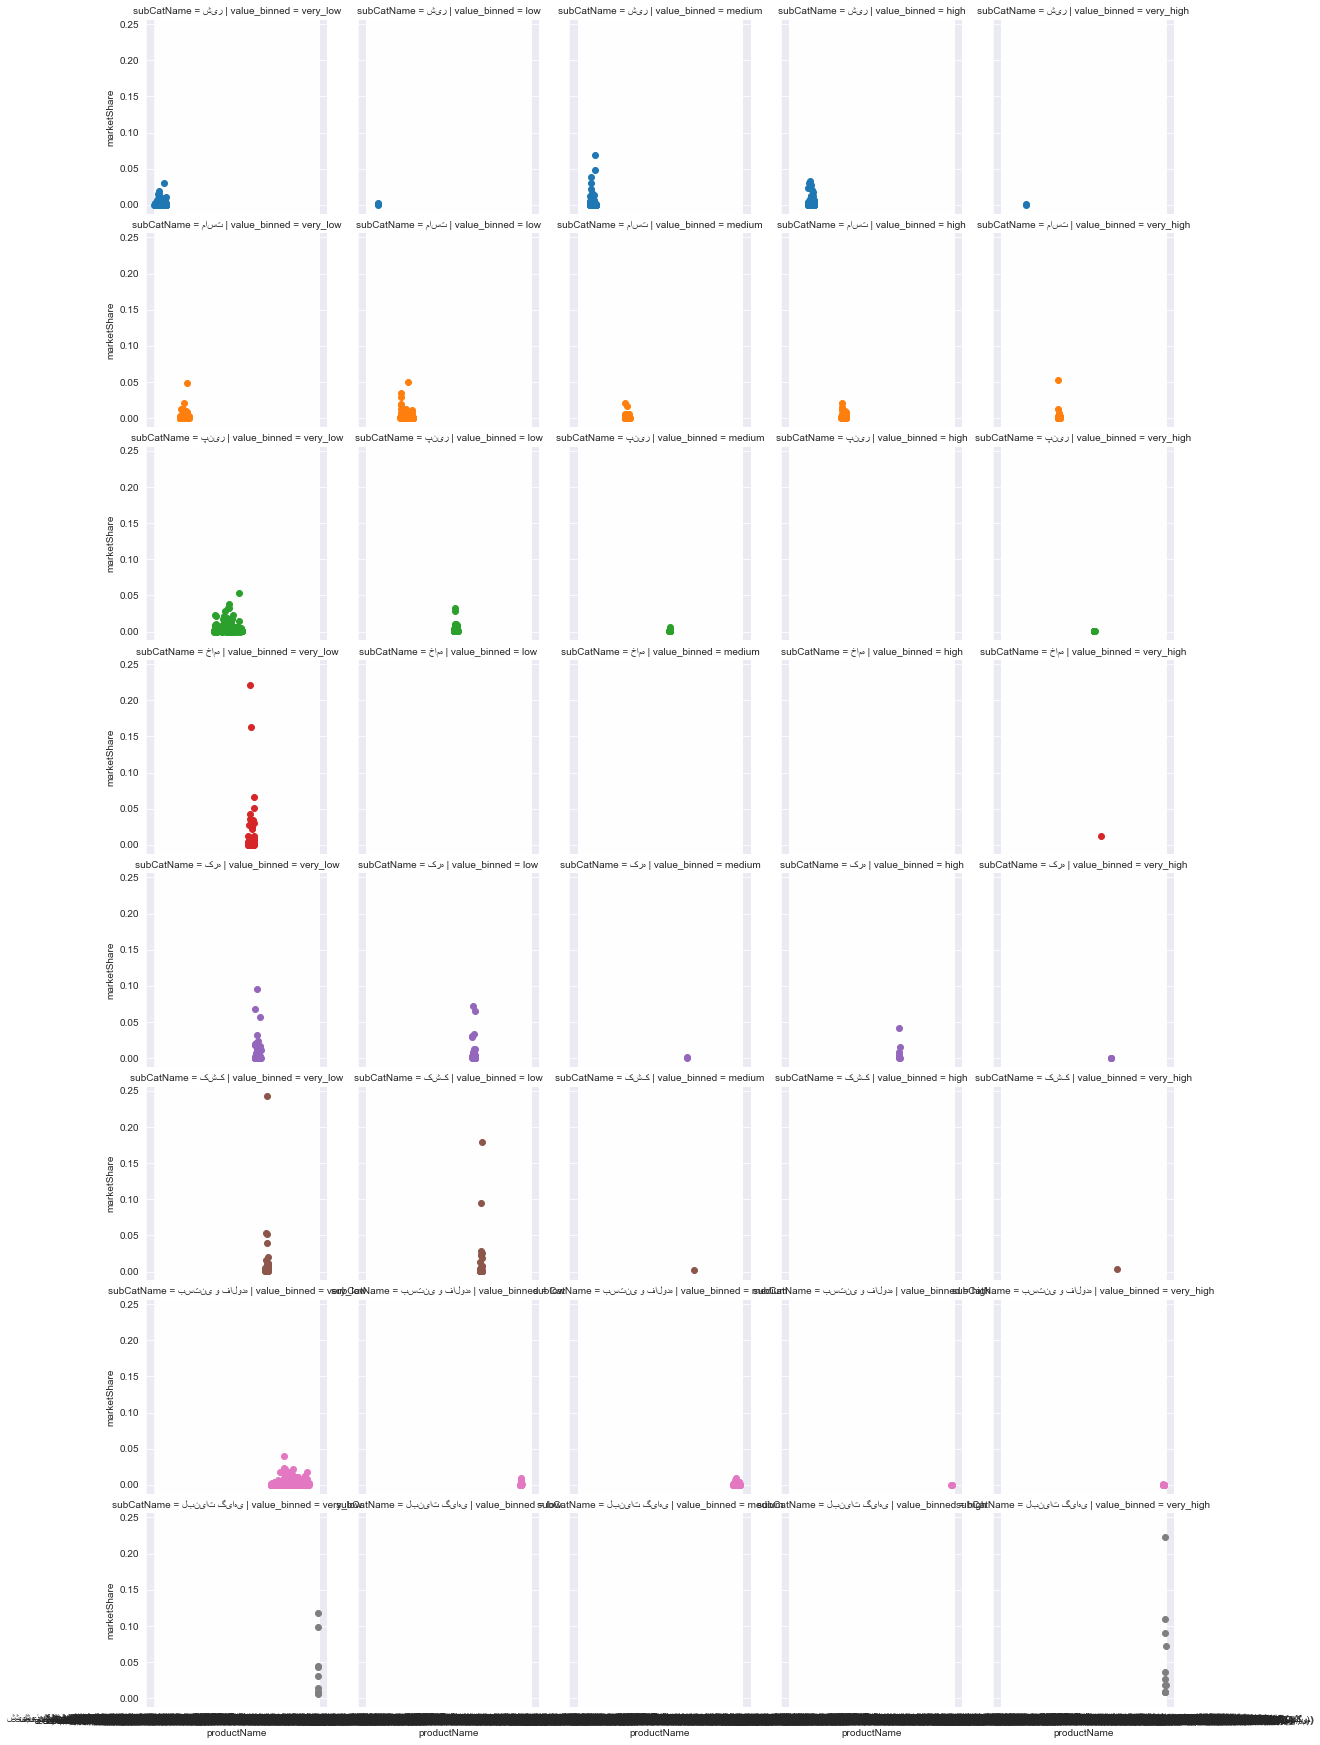

In [578]:
g = sns.FacetGrid(final_df, row='subCatName', col='value_binned', hue='subCatName')
kws=dict(s=100, linewidth=0.5, edgecolor='black')
g= g.map(plt.scatter, 'productName', 'marketShare',**kws)

In [534]:
df_order

,date,vendorID,orderID,userID,city,barcode,subCat,qty,price,sale,totalSale,avgPrice,storeTurnover,productStoreTurnover,customerNum
0,2021-10-01,53048,154341113,6636536,شیراز,6261792001949,نظافت و شستشو,1,24550,24550,795903,27850,441878161,4609186659,18
1,2021-10-01,53048,154343076,1478883,شیراز,80177173,محصولات صبحانه,1,100000,100000,19470350,99223,441878161,41750057926,138
2,2021-10-01,53048,154346508,260665,شیراز,6260002932776,چیپس،پفک،پاپ کورن,2,18000,36000,22479876,10337,441878161,328778470668,1452
3,2021-10-01,53048,154346508,260665,شیراز,6260687301935,پنیر,1,22500,22500,2615800,23185,441878161,34300441979,100
4,2021-10-01,53048,154346508,260665,شیراز,6262477911164,آجیل، چیپس میوه,2,10000,20000,36250450,7527,441878161,510144494430,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698825,2021-10-26,96695,160974809,4278163,قم,6260176817312,بستنی و فالوده,3,12000,36000,18127000,8478,30470615,133093801768,549
698826,2021-10-26,96695,161012223,10378476,قم,6260031022035,مراقبت و آرایش مو,1,13460,13460,450244,13839,30470615,4033556797,27
698827,2021-10-26,96695,161013804,4071003,قم,2770200021,سبزیجات و صیفی جات,1,10000,10000,6507254,13910,30470615,68155246635,280
698828,2021-10-26,96695,161027637,9845699,قم,6260176822736,بستنی و فالوده,2,6000,12000,2775000,5977,30470615,19326490022,125


#### Vendor-Num of orders

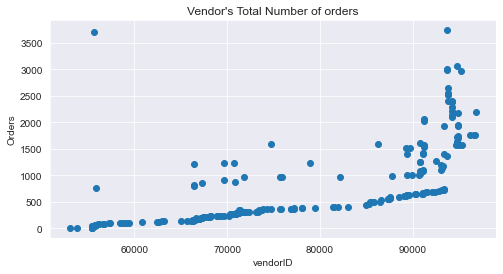

In [572]:
plt.scatter(x = df_order.vendorID.unique(), y =df_order.groupby('vendorID').agg({'orderID':pd.Series.nunique}).sort_values('orderID'))
plt.xlabel("vendorID") 
plt.ylabel("Orders") 
plt.title("Vendor's Total Number of orders") 
plt.show()

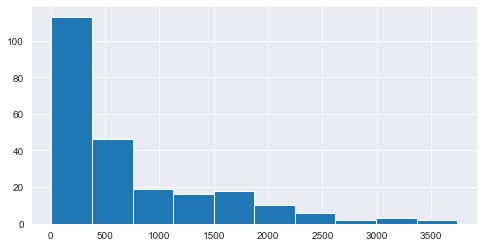

In [573]:
plt.hist(x = df_order.groupby('vendorID').agg({'orderID':pd.Series.nunique}).sort_values('orderID'))
plt.show()

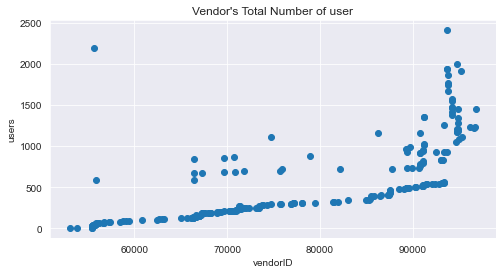

In [566]:
plt.scatter(x = df_order.vendorID.unique(), y =df_order.groupby('vendorID').agg({'userID':pd.Series.nunique}).sort_values('userID'))
plt.xlabel("vendorID") 
plt.ylabel("users") 
plt.title("Vendor's Total Number of user") 
plt.show()

ValueError: Length of DataFrame vectors must match length of `data` when both are used, but `data` has length 698830 and the vector passed to `x` has length 235.

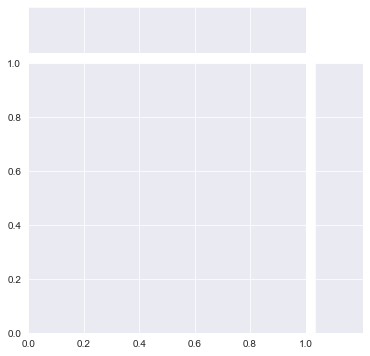

In [90]:
j = sns.jointplot(data=df_order, 
                  x=df_order.groupby('vendorID').agg({'userID':pd.Series.nunique}).sort_values('userID'),
                  y=df_order.groupby('vendorID').agg({'orderID':pd.Series.nunique}).sort_values('orderID'))

In [526]:
df_grp = dtf[0][['value_binned','avgPrice_binned','totalSale']].groupby(['value_binned','avgPrice_binned'],as_index=False).sum()
df_grp['totalSale'] = df_grp['totalSale'].astype('int32')
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   value_binned     25 non-null     category
 1   avgPrice_binned  25 non-null     category
 2   totalSale        25 non-null     int32   
dtypes: category(2), int32(1)
memory usage: 702.0 bytes


In [527]:
df_pivot = df_grp.pivot(index='value_binned',columns='avgPrice_binned')
df_pivot

totalSale                                        
avgPrice_binned   very_low        low    medium     high very_high
value_binned                                                      
very_low         208416496   47523750  21246000  2608700    100000
low                3330150     600000         0        0         0
medium            82338778  257207261   1801700        0     93200
high               1192125  309116985  27495460   690000         0
very_high                0          0   1935600        0         0

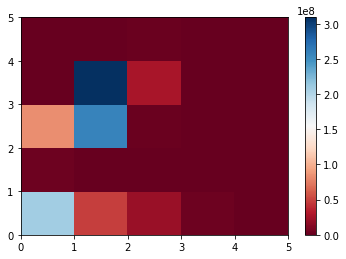

In [528]:
plt.pcolor(df_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'totalSale bins')

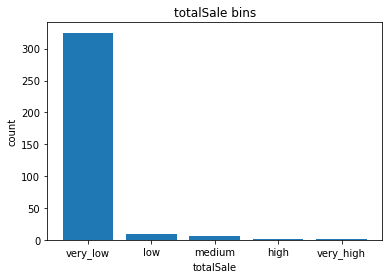

In [532]:
pyplot.bar(group_names, dtf[0]['totalSale_binned'].value_counts()) 
plt.pyplot.xlabel("totalSale") 
plt.pyplot.ylabel("count") 
plt.pyplot.title("totalSale bins") 

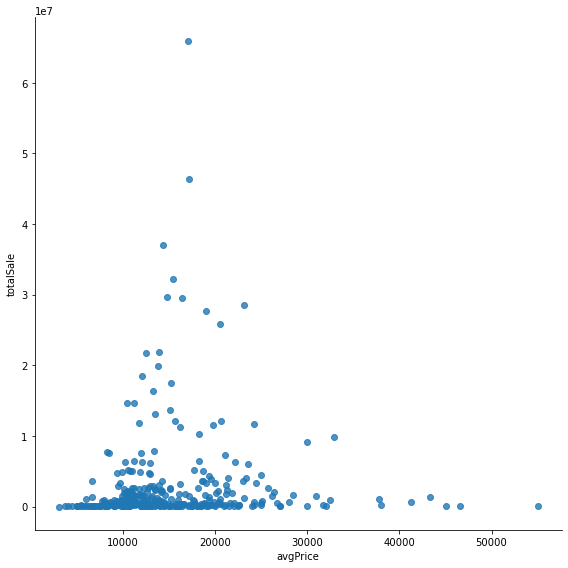

In [722]:
vis1 = sns.lmplot(data=dtf[0], x='avgPrice', y='totalSale',fit_reg=False, size=8)

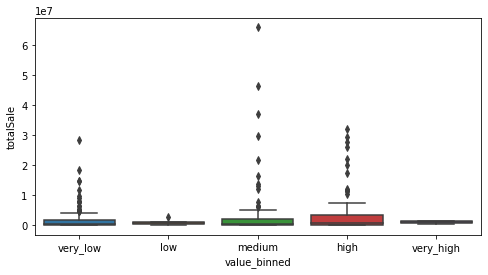

In [724]:
vis2 = sns.boxplot(data=dtf[0], x='value_binned', y='totalSale')

In [ ]:
for i in range(0,len(df_subCat)):
    d[i]['productavgprice'] = d[i]['productavgprice'].astype('int64')
    bins=np.linspace(d[i]['productavgprice'].min(),d[i]['productavgprice'].max(),4)
    group_names=["low","medium","high"]
    d[i]['price_binned']=pd.cut(d[i]['productavgprice'],bins, labels=group_names, include_lowest=True)

In [ ]:
dataset= pd.DataFrame()
for i in range(0,len(df_subCat)):
    dataset = dataset.append(d[i])

In [ ]:
dataset.columns = ['id','name','subCat','avgPrice','unit','value','sale','storeCount','storeSale','marketShare','numDist','weightDist','n_value','n_price','price_bin']

In [ ]:
dataset.loc[dataset.subCat== 'شیر', 'subCat'] = 'milk'
dataset.loc[dataset.subCat== 'ماست', 'subCat'] = 'yoghurt'
dataset.loc[dataset.subCat== 'پنیر', 'subCat'] = 'cheese'
dataset.loc[dataset.subCat== 'خامه', 'subCat'] = 'cream'
dataset.loc[dataset.subCat== 'بستنی و فالوده', 'subCat'] = 'ice-cream'
dataset.loc[dataset.subCat== 'کره', 'subCat'] = 'butter'
dataset.loc[dataset.subCat== 'لبنیات گیاهی', 'subCat'] = 'herbal-diary'
dataset.loc[dataset.subCat== 'کشک', 'subCat'] = 'kashk'

In [ ]:
dataset.subCat=dataset.subCat.astype('category')

In [ ]:
dataset.info()

In [ ]:
g = sns.FacetGrid(dataset , row='subCat' ,col='price_bin',  hue='subCat', sharex=False, sharey=False)
kws=dict(s=100, linewidth=0.5, edgecolor='black')
g= g.map(plt.scatter, 'value', 'sale',**kws)

In [ ]:
g = sns.FacetGrid(dataset , row='subCat' ,col='price_bin',  hue='subCat', sharex=False, sharey=False)
kws=dict(s=100, linewidth=0.5, edgecolor='black')
g= g.map(plt.scatter, 'weightDist', 'marketShare',**kws)

In [ ]:
g = sns.FacetGrid(dataset , row='subCat' ,col='price_bin',  hue='subCat', sharex=False, sharey=False)
kws=dict(s=100, linewidth=0.5, edgecolor='black')
g= g.map(plt.scatter, 'numDist', 'marketShare',**kws)

In [1052]:
dtf[0][['value','totalSale','avgPrice','customerNum','wghtDist']].corr()

,value,totalSale,avgPrice,customerNum,wghtDist
value,1.000000,0.145770,0.454555,0.194736,0.192492
totalSale,0.145770,1.000000,0.065329,0.949447,0.945420
avgPrice,0.454555,0.065329,1.000000,0.021830,0.034150
customerNum,0.194736,0.949447,0.021830,1.000000,0.987249
wghtDist,0.192492,0.945420,0.034150,0.987249,1.000000


In [526]:
df_grp = dtf[0][['value_binned','avgPrice_binned','totalSale']].groupby(['value_binned','avgPrice_binned'],as_index=False).sum()
df_grp['totalSale'] = df_grp['totalSale'].astype('int32')
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   value_binned     25 non-null     category
 1   avgPrice_binned  25 non-null     category
 2   totalSale        25 non-null     int32   
dtypes: category(2), int32(1)
memory usage: 702.0 bytes


In [527]:
df_pivot = df_grp.pivot(index='value_binned',columns='avgPrice_binned')
df_pivot

totalSale                                        
avgPrice_binned   very_low        low    medium     high very_high
value_binned                                                      
very_low         208416496   47523750  21246000  2608700    100000
low                3330150     600000         0        0         0
medium            82338778  257207261   1801700        0     93200
high               1192125  309116985  27495460   690000         0
very_high                0          0   1935600        0         0

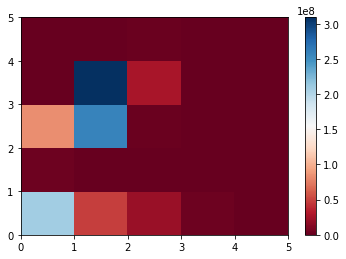

In [528]:
plt.pcolor(df_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'totalSale bins')

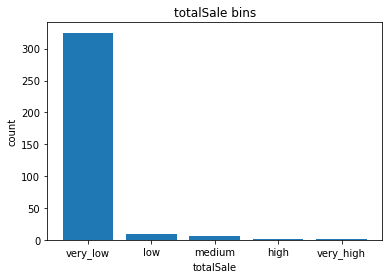

In [532]:
pyplot.bar(group_names, dtf[0]['totalSale_binned'].value_counts()) 
plt.pyplot.xlabel("totalSale") 
plt.pyplot.ylabel("count") 
plt.pyplot.title("totalSale bins") 

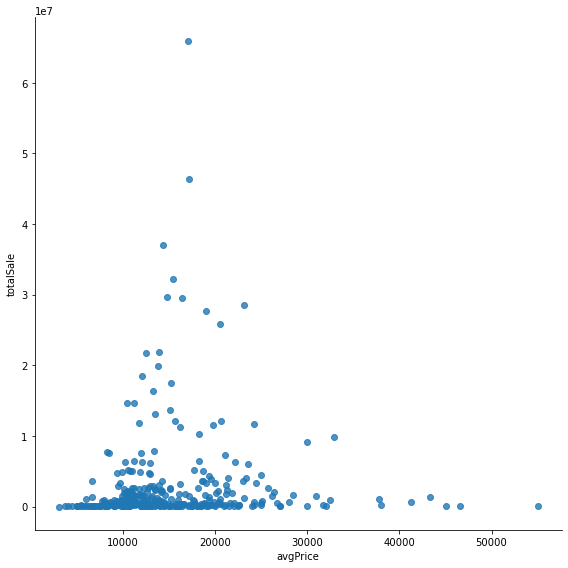

In [722]:
vis1 = sns.lmplot(data=dtf[0], x='avgPrice', y='totalSale',fit_reg=False, size=8)

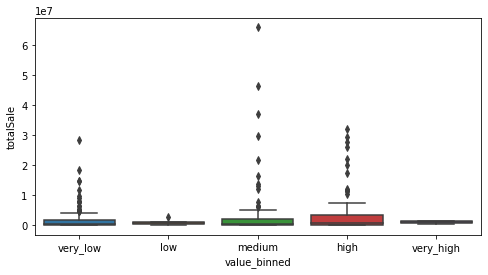

In [724]:
vis2 = sns.boxplot(data=dtf[0], x='value_binned', y='totalSale')